In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [84]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import pandas as pd
from itertools import accumulate
import numpy as np
from collections import defaultdict
import re
import random

from lib.sde.grn.grn4 import GRNMain4 as GRNMain
from lib.sde.mutate import mutate_grn4 as GRNMain
from lib.ga.utils import weighted_selection
from lib.ga.objective import Objective
from jf.profiler import Profiler
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L

from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback,
)

from lib.analyser import show_curve, show_curve_progenitor
from lib.utils import pick_best, pick_last
from jf.models.stringmodel import read_model

In [3]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)

In [4]:
class Solution:
    def __init__(self, grn):
        self.grn = grn
        
    def copy(self):
        return Solution(self.grn.copy())
        
    def mutate(self):
        mutate_grn(self.grn)

In [19]:
def get_bb(grn):
    ccls = factories["grn4"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
    )
    bb = BrainModel(time_step=0.5, verbose=False, start_population=7, max_pop_size=5e2,
            cell_cls=ccls, end_time=86, start_time=56, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks, record_population=True)
    return bb

In [20]:
def run_grn(prun, grn):
    get_bb(prun, grn)
    bb.run()
    return bb

In [21]:
exporter = Exporter(name="check_simple_obj_test")

Exporting at output/check_simple_obj_test


In [85]:
sm = read_model("generation")

In [88]:
sols = sum(list(map(exporter.load, filter(sm.match, exporter.list()))), [])

In [90]:
sols.sort(key=lambda x: x.id)

In [94]:
idmax = max(sols[-50:], key=lambda x: x.id)
idmax.id

2399

In [101]:
sols[300].id

500

In [22]:
sol = pick_best(exporter.load(pick_last(exporter)))

In [23]:
sol.grn

>> G_0: init: 2.25; noise: 0.53; b: 2.32; m: 7.39; expr: 1.00; deg: 0.10; theta: 0.66; asym: 3.21; tree : (5 OR 0)
>> G_1: init: 1.62; noise: 0.16; b: 0.90; m: 7.28; expr: 1.00; deg: 0.10; theta: 1.55; asym: 4.15; tree : 5
>> G_2: init: 1.24; noise: 0.21; b: 1.66; m: 1.07; expr: 1.00; deg: 0.10; theta: 4.63; asym: 2.86; tree : NOT 1
>> G_3: init: 0.85; noise: 0.19; b: 3.49; m: 9.57; expr: 1.00; deg: 0.10; theta: 4.49; asym: 3.62; tree : 2
>> G_4: init: 1.43; noise: 0.41; b: 0.59; m: 6.49; expr: 1.00; deg: 0.10; theta: 6.90; asym: 2.40; tree : NOT 5

In [24]:
bb = get_bb(sol.grn)

In [25]:
bb.run()

False

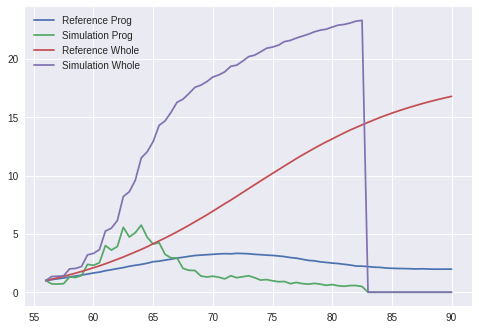

In [26]:
show_curve(bb.stats, REF.stats)

In [27]:
cell_hist = bb.build_cell_history()

In [28]:
def trace(bb, metric="activation"):
    mean_values = []
    sd_values = []
    
    timesteps = sorted(bb.snapshots.keys())
    
    for ts in timesteps:
        arr = []
        pop = bb.snapshots[ts]["population"]
        for c in pop.values():
            arr.append(c[metric])
        arr = np.asarray(arr)
        mean_values.append(arr.mean(axis=0))
        sd_values.append(arr.std(axis=0))
    
    mean_values = np.asarray(mean_values)
    sd_values = np.asarray(sd_values)
    dim = mean_values.shape[1]
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    for d in range(dim):
        plt.plot(timesteps, mean_values[:, d], label=f"G_{d}")
    plt.title("mean_" + metric)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    for d in range(dim):
        plt.plot(timesteps, sd_values[:, d], label=f"G_{d}")
    plt.title("sd_" + metric)
    plt.legend()

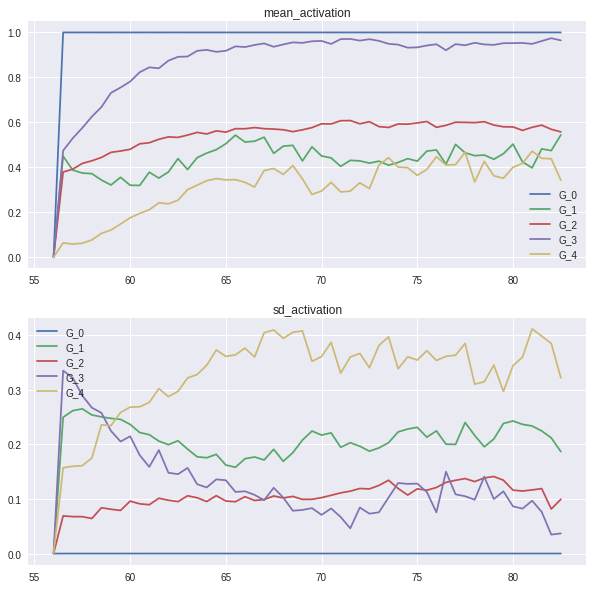

In [29]:
x = trace(bb, "activation")

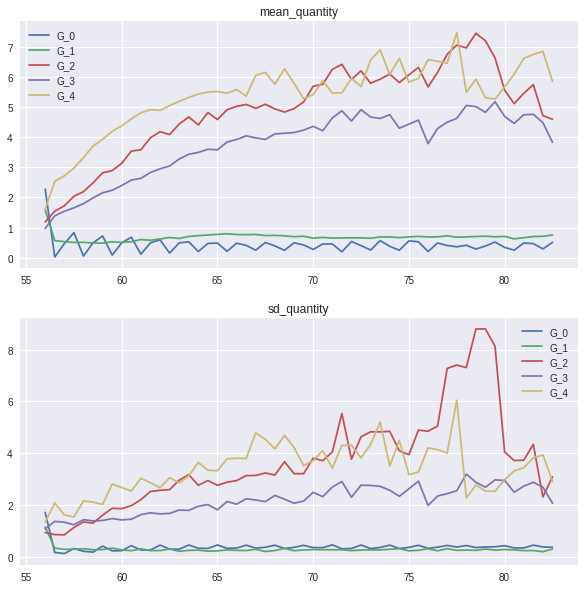

In [30]:
x = trace(bb, "quantity")

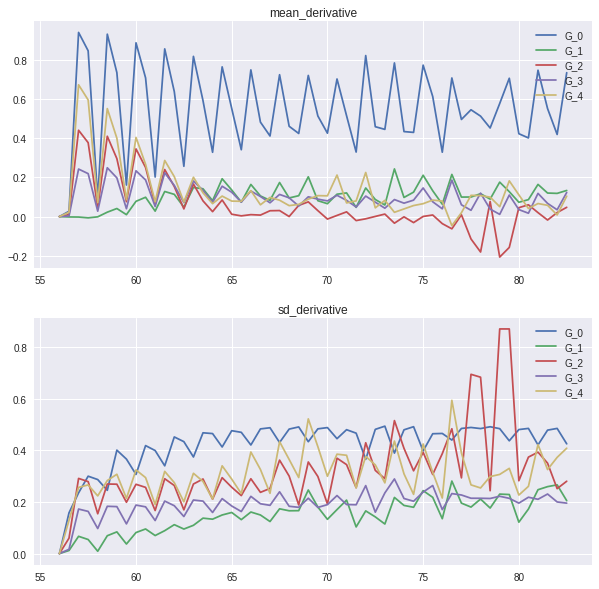

In [31]:
x = trace(bb, "derivative")

In [32]:
sol.grn

>> G_0: init: 2.25; noise: 0.53; b: 2.32; m: 7.39; expr: 1.00; deg: 0.10; theta: 0.66; asym: 3.21; tree : (5 OR 0)
>> G_1: init: 1.62; noise: 0.16; b: 0.90; m: 7.28; expr: 1.00; deg: 0.10; theta: 1.55; asym: 4.15; tree : 5
>> G_2: init: 1.24; noise: 0.21; b: 1.66; m: 1.07; expr: 1.00; deg: 0.10; theta: 4.63; asym: 2.86; tree : NOT 1
>> G_3: init: 0.85; noise: 0.19; b: 3.49; m: 9.57; expr: 1.00; deg: 0.10; theta: 4.49; asym: 3.62; tree : 2
>> G_4: init: 1.43; noise: 0.41; b: 0.59; m: 6.49; expr: 1.00; deg: 0.10; theta: 6.90; asym: 2.40; tree : NOT 5

In [75]:
from lib.score import fate_corr
from lib.preprocess import get_fmetric_pairs

In [79]:
pairs = get_fmetric_pairs(bb.population.base_population, 56, 66)
fate_corr(pairs)

0.10813344266540081

In [80]:
pairs = get_fmetric_pairs(bb.population.base_population, 66, 76)
fate_corr(pairs)

-0.05791483452904411

In [81]:
pairs = get_fmetric_pairs(bb.population.base_population, 56, 76)
fate_corr(pairs)

0.07106672620893084

## Lineage

In [33]:
cell_hist.head()

,Tc_h,appear_time,child1,child2,division_time,index,type
0,0.0,56.0,None,None,inf,0.0,PostMitotic
1,0.0,56.0,None,None,inf,1.0,PostMitotic
2,0.0,56.0,None,None,inf,2.0,PostMitotic
3,0.0,56.0,None,None,inf,3.0,PostMitotic
4,0.0,56.0,49,50,inf,4.0,Progenitor


In [34]:
cell_hist.loc[104]

Tc_h                       0
appear_time             57.5
child1                  None
child2                  None
division_time            inf
index                    104
type             PostMitotic
Name: 104, dtype: object

In [35]:
def get_cell_id_evolution(hist, index):
    cell = hist.loc[index]
    cell_trace = [(cell.appear_time, cell.name)]
    while True:
        if random.random() > 0.5:
            next_cell_id = cell.child1
        else:
            next_cell_id = cell.child2
        if next_cell_id is None:
            return cell_trace
        next_cell = hist.loc[int(next_cell_id)]
        cell_trace.append((next_cell.appear_time, next_cell.name))
        cell = next_cell

In [69]:
inp = get_cell_id_evolution(cell_hist, 4)
inp

[(56.0, 4),
 (56.0, 50),
 (57.0, 85),
 (58.5, 151),
 (60.0, 278),
 (61.5, 492),
 (63.0, 801),
 (64.5, 1143)]

In [70]:
def get_cell_id_timestep(id_evolution, ts=0.5):
    timesteps = []
    ids = []
    current_time, current_index = id_evolution[0]
    for t, idx in id_evolution[1:]:
        for i in np.arange(current_time + ts, t + ts, ts):
            timesteps.append(i)
            ids.append(current_index)
        current_time, current_index = t, idx
    return timesteps, ids

In [71]:
ts, ids = get_cell_id_timestep(inp)

In [72]:
def trace_evolution(bb, ts, ids, metric="quantity"):
    values = []
    for t, idx in zip(ts, ids):
        cell = bb.snapshots[t]["population"][idx]
        values.append(cell[metric])
    
    values = np.asarray(values)
    
    for d in range(values.shape[1]):
        plt.plot(ts, values[:, d], label=f"G_{d}")
    plt.title("mean_" + metric)
    plt.ylim(0, 5)
    plt.legend()

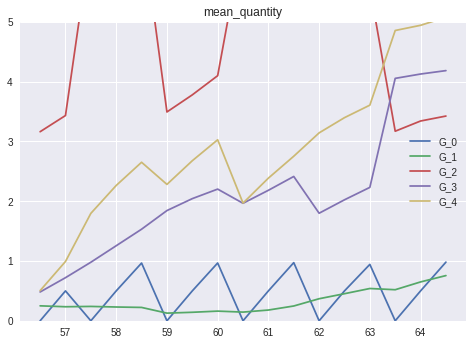

In [73]:
trace_evolution(bb, ts, ids)

In [69]:
print(list(zip(*inp))[0])

(56.0, 56.5, 59.0, 61.0, 63.5, 65.0, 66.5, 68.0, 70.0, 72.5, 76.0, 77.5, 79.0, 81.0)


# Analysis of v3

In [70]:
exporter = Exporter(name="checkperf_2102_v3")
res = L(exporter.load("generation_g24"))

Exporting at output/checkperf_2102_v3


In [71]:
sol = res[res.fit.index(max(res.fit))]

In [72]:
sol.grn

>> G_0: init: 1.54; noise: 7.53; b: 0.68; m: 3.25; expr: 1.00; deg: 0.00; theta: 0.72; asym: 1.17; tree : 4
>> G_1: init: 0.90; noise: 6.97; b: 1.45; m: 3.57; expr: 1.00; deg: 0.00; theta: 9.82; asym: 9.03; tree : ((2 OR 4) AND NOT 0)
>> G_2: init: 0.33; noise: 4.59; b: 1.45; m: 1.36; expr: 1.00; deg: 0.50; theta: 0.87; asym: 5.03; tree : (3 AND 2)
>> G_3: init: 0.27; noise: 7.79; b: 2.97; m: 2.94; expr: 1.00; deg: 2.45; theta: 14.94; asym: 3.16; tree : (NOT NOT 3 AND 2)
>> G_4: init: 0.20; noise: 9.54; b: 2.07; m: 2.81; expr: 1.00; deg: 0.00; theta: 1.63; asym: 2.71; tree : NOT (5 OR 4)

In [73]:
bb = get_bb(sol.grn)

In [74]:
bb.run()

True

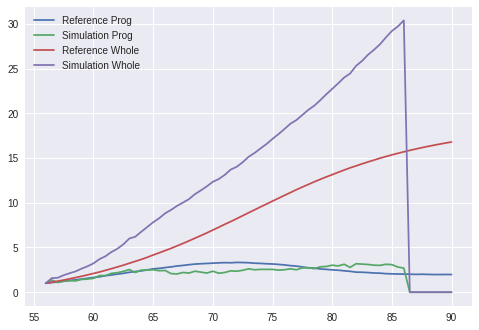

In [75]:
show_curve(bb.stats, REF.stats)

In [76]:
len(bb.snapshots)

61

In [77]:
cell_hist = bb.build_cell_history()

In [78]:
[len(x["population"]) for x in bb.snapshots.values()][:10]

[49, 67, 53, 61, 63, 62, 70, 72, 76, 91]

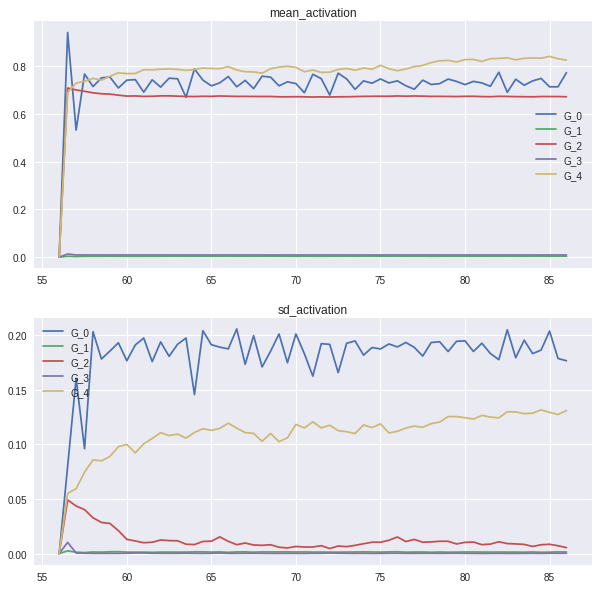

In [79]:
x = trace(bb, "activation")

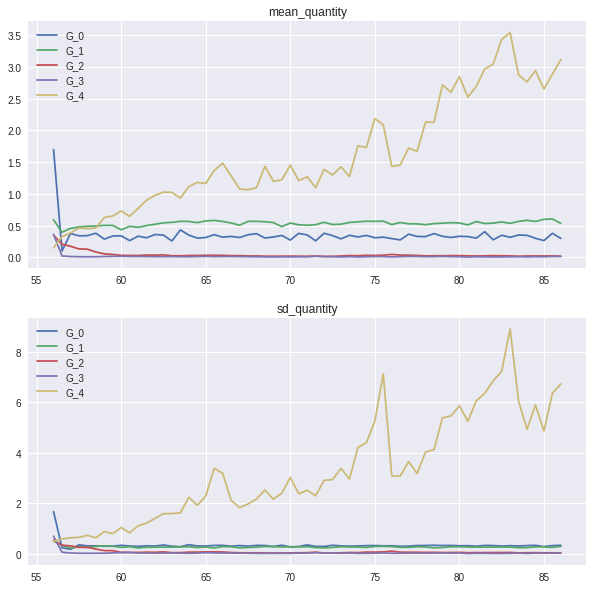

In [80]:
x = trace(bb, "quantity")

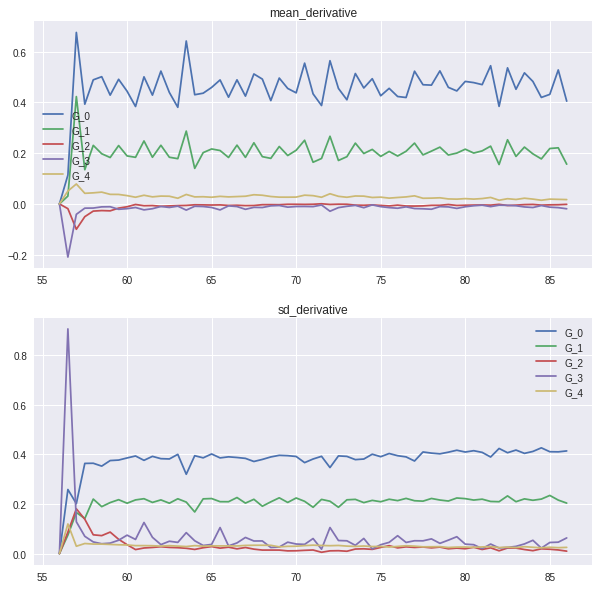

In [81]:
x = trace(bb, "derivative")

In [82]:
sol.grn

>> G_0: init: 1.54; noise: 7.53; b: 0.68; m: 3.25; expr: 1.00; deg: 0.00; theta: 0.72; asym: 1.17; tree : 4
>> G_1: init: 0.90; noise: 6.97; b: 1.45; m: 3.57; expr: 1.00; deg: 0.00; theta: 9.82; asym: 9.03; tree : ((2 OR 4) AND NOT 0)
>> G_2: init: 0.33; noise: 4.59; b: 1.45; m: 1.36; expr: 1.00; deg: 0.50; theta: 0.87; asym: 5.03; tree : (3 AND 2)
>> G_3: init: 0.27; noise: 7.79; b: 2.97; m: 2.94; expr: 1.00; deg: 2.45; theta: 14.94; asym: 3.16; tree : (NOT NOT 3 AND 2)
>> G_4: init: 0.20; noise: 9.54; b: 2.07; m: 2.81; expr: 1.00; deg: 0.00; theta: 1.63; asym: 2.71; tree : NOT (5 OR 4)

## Lineage

In [83]:
cell_hist.head()

,Tc_h,appear_time,child1,child2,division_time,index,type
0,0.0,56.0,49,50,inf,0.0,Progenitor
1,0.0,56.0,109,110,inf,1.0,Progenitor
2,0.0,56.0,51,52,inf,2.0,Progenitor
3,0.0,56.0,53,54,inf,3.0,Progenitor
4,0.0,56.0,55,56,inf,4.0,Progenitor


In [84]:
cell_hist.loc[104]

Tc_h                      0
appear_time              56
child1                  157
child2                  158
division_time           inf
index                   104
type             Progenitor
Name: 104, dtype: object

In [104]:
inp = get_cell_id_evolution(cell_hist, 0)
inp

[(56.0, 0),
 (56.0, 49),
 (57.5, 137),
 (59.0, 221),
 (60.0, 308),
 (62.0, 437),
 (63.5, 574),
 (64.5, 707)]

In [105]:
ts, ids = get_cell_id_timestep(inp)

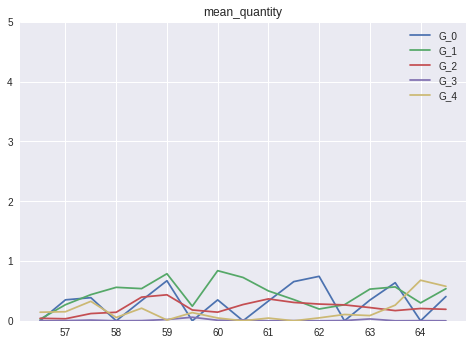

In [106]:
trace_evolution(bb, ts, ids)

In [107]:
print(list(zip(*inp))[0])

(56.0, 56.0, 57.5, 59.0, 60.0, 62.0, 63.5, 64.5)
